### Data

The sentiment analysis model within this notebook uses publicly available datasets:

1. Large Movie Review Dataset: https://ai.stanford.edu/~amaas/data/sentiment/
2. Sentiment Polarity Dataset (v1 and v2): https://www.cs.cornell.edu/people/pabo/movie-review-data/

All data is contained in the "data" directory (not committed in this repo).
The code below assumes the same directory structure as the original datasets under the root "data" folder.

In [2]:
import os
from dataset_utils import *

train_path = os.path.join(IMDB_DATA_PATH, "train")
test_path  = os.path.join(IMDB_DATA_PATH, "test")

#Main training set - Large Movie Review Dataset (IMDB)
((train_texts, train_labels), (test_texts, test_labels)) = load_imdb_dataset(train_path=train_path, test_path=test_path)

#Review Polarity Datasets - used as additional test data
(v1_texts, v1_labels), (v2_texts, v2_labels) = load_polarity(v1_path=POLARITY_v1_DATA_PATH, v2_path=POLARITY_v2_DATA_PATH)

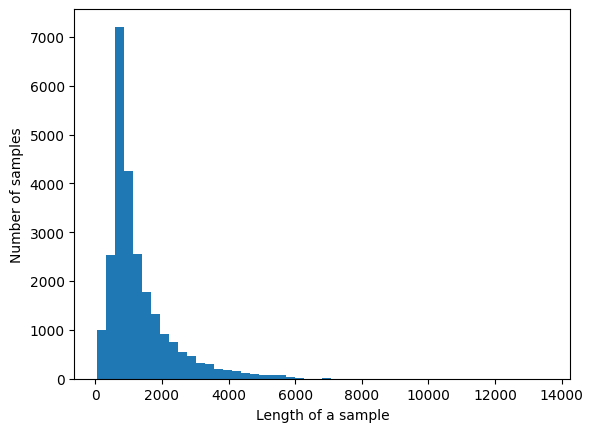

In [3]:
import matplotlib.pyplot as plt

plt.hist([len(text) for text in train_texts], 50)
plt.xlabel("Length of a sample")
plt.ylabel("Number of samples")
plt.show()

In [21]:
import torch

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif


MAX_FEATURES = 5000

transformer_pipeline = Pipeline([
    ('vect', TfidfVectorizer(min_df=5, ngram_range=(1,2))),
    ('select', SelectKBest(k=MAX_FEATURES))
])

transformed_train = transformer_pipeline.fit_transform(train_texts, train_labels)
transfomed_test  = transformer_pipeline.transform(test_texts)

X_train = torch.from_numpy(transformed_train.toarray()).to(dtype=torch.float32)
X_test  = torch.from_numpy(transfomed_test.toarray()).to(dtype=torch.float32)

X_test_v1 = torch.from_numpy(transformer_pipeline.transform(v1_texts).toarray()).to(dtype=torch.float32)
X_test_v2 = torch.from_numpy(transformer_pipeline.transform(v2_texts).toarray()).to(dtype=torch.float32)

In [32]:
selector = transformer_pipeline.named_steps['select']
len(selector.get_feature_names_out())

5000

In [23]:
vectorizer = transformer_pipeline.named_steps['vect']
ngrams = vectorizer.get_feature_names_out()

In [29]:
len(transformed_train.sum(axis=0).A1)

5000

In [ ]:
y_train = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1)
y_test  = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1)

y_test_v1 = torch.tensor(v1_labels, dtype=torch.float32)
y_test_v2 = torch.tensor(v2_labels, dtype=torch.float32)

In [ ]:
from torch import nn

input_dim = X_train.shape[1]

class SentimentCLF(nn.Module):
    def __init__(self, n_units, dropout_p):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_dim, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, 1)
        )
            
        self.dropout = nn.Dropout(p=dropout_p)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        dropped = self.dropout(x)
        logits = self.linear_stack(dropped)
        
        return logits

In [ ]:
from skorch import NeuralNetClassifier

net = NeuralNetClassifier(
    module=SentimentCLF,
    module__n_units=100,
    module__dropout_p=0.5,
    lr = 0.001,
    criterion=nn.BCEWithLogitsLoss,   
    device='cuda',
    max_epochs=15,
    optimizer=torch.optim.Adam,
    batch_size=64,
)

In [ ]:
from sklearn.model_selection import GridSearchCV


net.set_params(train_split=False, verbose=0)

param_grid = {
    'module__dropout_p': [0.6],
    'module__n_units': [100, 300, 500, 1000],
    'lr': [0.0001, 0.001]
}

gs = GridSearchCV(net, param_grid=param_grid, refit=False, cv=3, scoring='accuracy', verbose=3)
gs.fit(X_train, y_train)
print(gs.best_score_, gs.best_params_)

In [ ]:
b_params_1 = {'module__dropout_p': 0.5, 'module__n_units': 100}
b_params_2 = {'lr': 0.0001, 'module__dropout_p': 0.6, 'module__n_units': 1000}

In [ ]:
net.set_params(**gs.best_params_)
net.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

for X, y in [(X_test, y_test), (X_test_v1, y_test_v1), (X_test_v2, y_test_v2)]:
    pred = net.predict(X)
    print(accuracy_score(pred, y))